# Setup

In [1]:
# Imports
import math

#For prettifying large numbers
from matplotlib.ticker import EngFormatter 
engFormatter = EngFormatter()
# For making electronic schematics
import schemdraw
import schemdraw.elements as elm

In [2]:
# SI unit-prefixes class
class si :
    """
    This is a simple class that provides an easy way to access the engineering prefixes for the metric system.
    Example:
        25*si.k results in 25_000
    """
    Y = 10**24  # Yotta
    Z = 10**21  # Zetta
    E = 10**18  # Exa
    P = 10**15  # Peta
    T = 10**12  # Tera
    G = 10**9   # Giga
    M = 10**6   # Mega
    k = 10**3   # kilo

    m = 10**-3  # milli
    µ = 10**-6  # micro
    u = 10**-6  # micro ## so that we can type u instead of µ
    n = 10**-9  # nano
    p = 10**-12 # pico
    f = 10**-15 # femto
    a = 10**-18 # atto
    z = 10**-21 # zepto
    y = 10**-24 # yocto


In [3]:
# Useful functions
def recipsumrecip(data):
    """Useful for calculating parallel resistances. Expects an iterable as input."""
    denom = 0
    for n in data:
        denom += 1/n
    return 1/denom

def two_pi(n):
    """Multiplies a number by 2*pi. Useful for not having to type 2*math.pi as often."""
    return 2*math.pi*n

# Experiment 1

In this lab we will explore the frequency response of an amplifier.

Using MultiSim build this circuit:

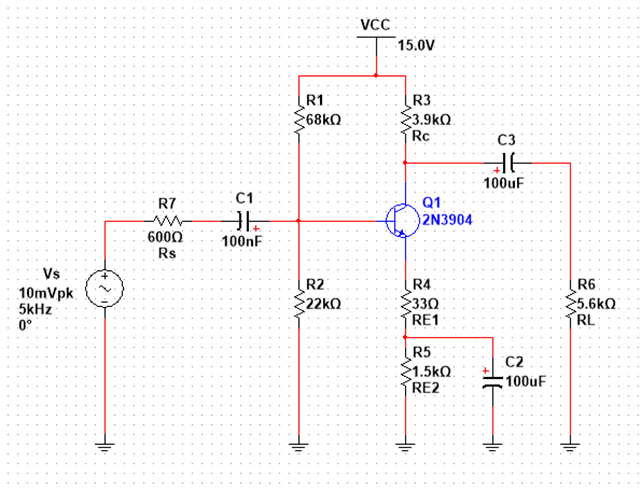

### $\beta_{ac}$

Measure the current at the collector ($I_C$) and at the base ($I_B$) to determine the beta gain ($\beta_{ac}$).

$$
\beta_{ac} = \frac{I_C}{I_B}
$$

In [4]:
I_C = 1.81*si.m #Amps RMS (measured)
I_B = 12.1*si.u #Amps RMS (measured)

beta_ac = I_C/I_B #Unit-less
print(engFormatter(beta_ac))

149.587


### $r'_e$

Next we will want to find the small-signal emitter resistance ($r'_e$), which is not like a physical resistor; it is a dynamic or incremental resistance that represents the change in emitter voltage with respect to the change in emitter current in a transistor.  To find it we will find the current through the emitter ($I_E$).
$$
I_E = I_C+I_B
$$

Then we can calculate $r'_e$:
$$
r'_e = \frac{V_T}{I_E}
$$

The thermal voltage ($V_T$) represents the voltage equivalent of thermal energy at a given temperature; at room temperature (20°C or 293.15K) is approximately 25.2 millivolts (mV). It can be calculated directly, but for most purposes we will simplify it as 25 mV.

$$
r'_e = \frac{25 mV}{I_E}
$$

In [5]:
I_E = I_C+I_B
print(engFormatter(I_E))

1.8221 m


In [6]:
V_T = 25*si.m #volts
r_e = V_T/I_E #Ohms
print(engFormatter(r_e),'Ω')

13.7204 Ω


### Gain

Next we are interested in finding the voltage gain of the amplifier.
$$
\text{gain} = \frac{\text{out}}{\text{in}}
$$

We'll want to measure the voltages of the input and output signals.

In [7]:
v_in = 7.07*si.m    #Volts (RMS)
v_out = 298.79*si.m #Volts (RMS)

gain = v_out/v_in   #Unit-less
print(engFormatter(gain))

42.2617


That number by itself is useful, but can quickly balloon out of control. Therefore we will want to convert it to Decibels. For voltage we use a constant of 20.
$$
V_{DB} = 20\cdot \log({\text{gain}})
$$

In [8]:
v_db = 20*math.log10(gain)
print(engFormatter(v_db),'DB')

32.5189 DB


### Cutoff frequencies

Now we arrive at the core of this experiment: are we able to predict the cutoff frequencies for this amplifying circuit?

The circuit makes use of three separate capacitors (to isolate the input and outputs from the main voltage, as well as a bypass capacitor) and several resistors (to establish a stable Q-point). In earlier works, we explored how find the critical frequency of an RC circuit using the following formula.

$$
\begin{align}
X_C &= \frac{1}{2 \pi f_c C} = R \\
\\
f_c &= \frac{1}{2 \pi R C}

\end{align}
$$

We can apply this formula by treating the amplifying circuit as three distinct circuits and calculating each circuit's respective cutoff frequency. The lower cutoff frequency of the amplifier will be the highest frequency among the three.

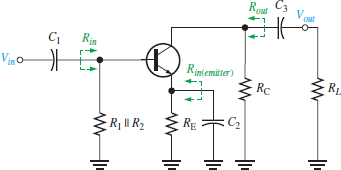

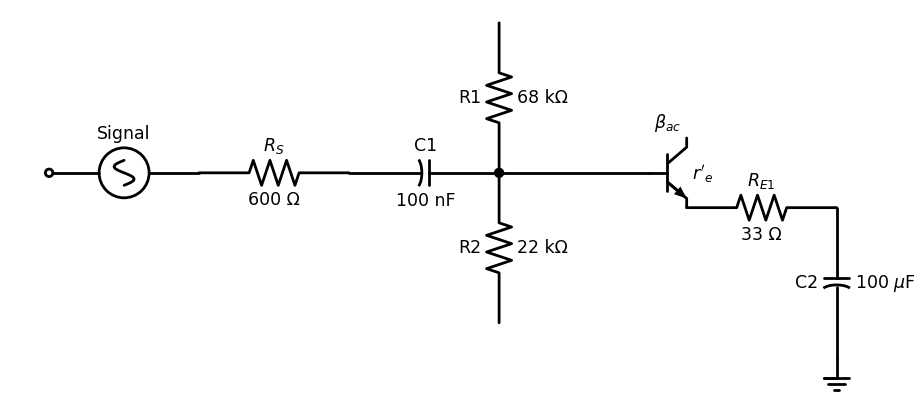

In [9]:
# Drawing of subcircuit 1
with schemdraw.Drawing() as d:
    elm.Dot(open=True)
    elm.SourceSin(label='Signal').right()
    elm.Resistor().label('$R_S$',loc='top').label('600 Ω',loc='bottom')
    c1 = elm.Capacitor2().reverse().label('C1', loc='top').label('100 nF',loc='bottom').dot()
    elm.Line()
    elm.BjtNpn().label(r'$\beta_{ac}$',loc='top').label("$r'_e$",loc='right').drop('emitter')
    elm.Resistor().label('$R_{E1}$',loc='top').label('33 Ω',loc='bottom')
    elm.Capacitor2().down().label('C2',loc='top').label('100 $\mu$F',loc='bottom')
    elm.Ground()
    elm.Resistor().up().label('R1',loc='top').label('68 kΩ',loc='bottom').at(c1.end)
    elm.Resistor().down().label('R2',loc='top').label('22 kΩ',loc='bottom').at(c1.end)
    # elm.Ground()

Subcircuit 1
$$
f_{c1} = \frac{1}{2\pi(R_S + (R_1|R_2|(\beta_{ac}*(r'_e + R_{E1}))))*C_1}
$$

In [10]:
# Calculating formula for F_c1

C1 = 100*si.n   # Farads
R_S = 600       # Ohms
R_1 = 68*si.k   # Ohms
R_2 = 22*si.k   # Ohms
R_E1 = 33       # Ohms
R_E2 = 1.5*si.k # Ohms

resistance_at_base = beta_ac*(r_e+R_E1)
print("resistance_at_base:",engFormatter(resistance_at_base))

parallel_resistance = recipsumrecip([R_1,R_2,resistance_at_base])
print("parallel_resistance:",engFormatter(parallel_resistance))

input_resistance = R_S + parallel_resistance


f_c1 = 1/(2*math.pi*input_resistance*C1) #Hz

print("f_c1:", engFormatter(f_c1), 'Hz')

resistance_at_base: 6.98876 k
parallel_resistance: 4.92011 k
f_c1: 288.318 Hz


Subcircuit 2
$$
f_{c2} = \frac{1}{2\pi(R_{E2} | (\frac{R_1|R_2|R_S}{\beta_{ac}}+r'_e + R_{E1}))*C_2}
$$


In [11]:
C2 = 100*si.u #Farads

r_in_emitter = recipsumrecip([R_1,R_2,R_S])/beta_ac
print('r_in_emitter',engFormatter(r_in_emitter))

series_resistance = r_in_emitter + r_e + R_E1
print('series_resistance',engFormatter(series_resistance))

total_resistance = recipsumrecip([R_E2,series_resistance])
print('total_resistance',total_resistance)

f_c2 = 1/(2*math.pi*total_resistance*C2)
print('f_c2',engFormatter(f_c2))

r_in_emitter 3.87131
series_resistance 50.5917
total_resistance 48.94106650873106
f_c2 32.5197


Subcircuit 3
$$
f_{c3} = \frac{1}{2\pi(R_C + R_L)*C_3}
$$

In [12]:
R_C = 3900
R_L = 5600
C_3 = 100*si.u 
f_c3 = 1/(2*math.pi*(R_C+R_L)*C_3)

print('f_c3', engFormatter(f_c3))

f_c3 167.532 m


### High cutoff frequency

In [13]:
C_obo = 4*si.p #Farads
C_ibo = 9*si.p #Farads

In [14]:
C_bc = C_obo
C_be = C_ibo

In [18]:
parallel_resistance

4920.113356009497

In [27]:
C_miller = C_bc*(1+gain)/gain

R_ac = recipsumrecip([3.9*si.k,5.6*si.k])

f_ch = 1/(two_pi(R_ac*C_miller))

engFormatter(f_ch)

'16.9073 M'

# Extra experiments  

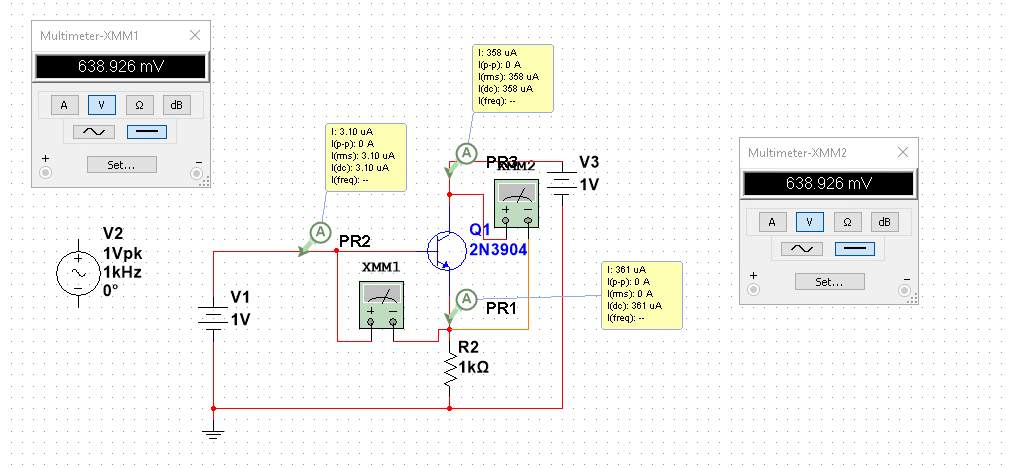

In [28]:
1/(358*si.u)

2793.296089385475

In [32]:
rPrime_e = (25*si.m)/(361*si.u)
rPrime_e


69.25207756232687

In [33]:
I_E = 358*si.u
I_B = 3.1*si.u
beta = I_E/I_B
beta

115.48387096774192

In [59]:
V = 1-.639
observed_base_resistance = V/I_B
engFormatter(observed_base_resistance)

'116.452 k'

In [49]:
R = 1000
engFormatter(beta*(rPrime_e+R))

'123.481 k'